<h1>Windows Virtual Desktop with Azure AD Domain Services</h1>

<h2>This document was created to guide someone to creating a Windows Virtual Desktop with an instance of Azure AD Domain Services.</h2>

The Windows Virtual Desktop will be created with FSLogix for the user profiles.  Those profiles will be pointed to an Azure File Share on premium storage.


<h3>Connect to Azure</h3>



In [ ]:
# Connect to Azure
if (get-module -list | where name -match "az"){
    Write-Host "The Az module is installed"
    Write-Host "Connecting to Azure with the Az module"
    connect-azaccount
} else {
    Write-Host "The Az module is NOT installed"
    Write-Host "Installing Az module"
    Install-Module Az
    Write-Host "Importing AzureAD module"
    Import-Module Az
    Write-Host "Connecting to Azure with the Az module"
    connect-azaccount
}


<h3>Create a Resource Group</h3>

In [ ]:
# Create a resource group
$global:rgName = 'rg-coreinfrastructure'
$global:region = 'eastus'
try {
    $rgExists = Get-AzResourceGroup -Name $rgName
} finally {}

if ($rgExists -ne $null){
    Write-Host "The resource group has already been created"
} else {
    New-AzResourceGroup -Name $rgName -Location $region
}


This infrastructure within this resource group will include...

    - An Azure Active Directory Domain Services domain
    - A virtual network
    - A subnet for the AADDS and one for WVD
    - A management VM for the WVD

<h3>Create the virtual network and subnets</h3>

In [ ]:
$global:vnetName = "core-vnet"

# Create the dedicated subnet for Azure AD Domain Services.
$global:subnetName = "aadds-subnet"
$global:aaddsSubnet = New-AzVirtualNetworkSubnetConfig `
  -Name $subnetName `
  -AddressPrefix 10.0.100.0/24

# Create an additional subnet for your own VM workloads
$global:workloadSubnet = New-AzVirtualNetworkSubnetConfig `
  -Name workloads-subnet `
  -AddressPrefix 10.0.110.0/24
  
# Create an additional subnet for your own VM workloads
$global:WVDSubnet = New-AzVirtualNetworkSubnetConfig `
  -Name wvd-subnet `
  -AddressPrefix 10.0.120.0/24

# Create the virtual network in which you will enable Azure AD Domain Services.
$vnetExists = Get-AzVirtualNetwork -Name $vnetName
if ($vnetExists -ne $null){
    Write-Host "The virtual network already exists."
} else {
    $vnet = New-AzVirtualNetwork -ResourceGroupName $rgName -Location $region -Name $vnetName -AddressPrefix 10.0.0.0/16 -Subnet $aaddsSubnet,$workloadSubnet,$WVDSubnet
}

<h3>Create the AADDS into the Resource Group</h3> 

We will create a service principal account and then add it to the AAD DC Administrators group.
We will then register the Azure AD Domain Services resource provider.

<h4>Add the Posh Test Gallery Repository</h4>

This is so that you can use the AzureAD module on Powershell Core.  It is not supported in the current version for Powershell

In [ ]:
Write-Host "Adding the Posh Test Gallery for the AzureAD that can be used with Powershell Core"
$packageSource = Get-PackageSource -Name 'Posh Test Gallery'

if (!$packageSource)
{
	$packageSource = Register-PackageSource -Trusted -ProviderName 'PowerShellGet' -Name 'Posh Test Gallery' -Location 'https://www.poshtestgallery.com/api/v2/'
}

<h4>Import the AzureAD Module and Connect</h4>

In [ ]:
# Check if module is installed
$module = Get-Module 'AzureAD.Standard.Preview' -ListAvailable -ErrorAction SilentlyContinue

if (!$module) 
{
  Write-Host "Installing module AzureAD.Standard.Preview ..."
  $module = Install-Module -Name 'AzureAD.Standard.Preview' -Force -Scope CurrentUser -SkipPublisherCheck -AllowClobber 
  Write-Host "Module installed"
}

# Module doesn't automatically load after install - need to import explictly for Pwsh Core
Import-Module -Name $module.RootModule

$id = (Get-AZTenant).id
Connect-AzureAD -tenantid $id

<h3>Create the New Service Principal and AAD DC Administrators Group</h3>

In [ ]:
# Create the service principal for Azure AD Domain Services
try {
    Write-Host "Creating service principal for Azure AD DS"
    New-AzureADServicePrincipal -AppId "2565bd9d-da50-47d4-8b85-4c97f669dc36"
} finally {}

# First, retrieve the object ID of the 'AAD DC Administrators' group.
$GroupObjectId = Get-AzureADGroup -Filter "DisplayName eq 'AAD DC Administrators'" | Select-Object ObjectId

# If the group doesn't exist, create it
if (!$GroupObjectId) {
    Write-Host "Creating AAD DC Administrators group"
    $GroupObjectId = New-AzureADGroup -DisplayName "AAD DC Administrators" `
    -Description "Delegated group to administer Azure AD Domain Services" `
    -SecurityEnabled $true `
    -MailEnabled $false `
    -MailNickName "AADDCAdministrators"
  }
else {
  Write-Output "Admin group already exists."
}

# Retrieve the object ID of the user you'd like to add to the group.
$UserObjectId = Get-AzureADUser `
  -Filter "UserPrincipalName eq 'cmccray@mccrayprojects.com'" | Select-Object ObjectId

# Add the user to the 'AAD DC Administrators' group.
$members = Get-AzADGroup -ObjectId $groupobjectid.objectid | get-azadgroupmember

if($members -eq $null){
    Write-Host "Add user to the AAD DC Administrators group"
    Get-AzADGroup -ObjectId $groupobjectid.objectid | Add-AzADGroupMember -memberobjectid $userobjectid.objectid
} else {
    Write-Host "User is in group"
}

# Retrieve the object ID of the 'WVD Users' group.
$global:WVDGroupObjectId = Get-AzureADGroup -Filter "DisplayName eq 'WVD_Users'" | Select-Object ObjectId

# If the group doesn't exist, create it
if (!$WVDGroupObjectId) {
    Write-Host "Creating WVD_Users group"
    $WVDGroupObjectId = New-AzureADGroup -DisplayName "WVD_Users" `
    -Description "Delegated group to add users to WVD" `
    -SecurityEnabled $true `
    -MailEnabled $false `
    -MailNickName "WVD_Users"
  }
else {
  Write-Output "WVD_Users group already exists."
}

# First, register the Azure AD Domain Services resource provider
Write-Host "Register Microsoft.AD provider"
Register-AzResourceProvider -ProviderNamespace Microsoft.AAD



<h3>Create the NSG for Azure AD Domain Services</h3>

In [ ]:
$NSGName = "aaddsNSG"

# Create a rule to allow TCP port 5986 traffic for PowerShell remote management
$nsg301 = New-AzNetworkSecurityRuleConfig -Name AllowPSRemoting `
    -Access Allow `
    -Protocol Tcp `
    -Direction Inbound `
    -Priority 301 `
    -SourceAddressPrefix AzureActiveDirectoryDomainServices `
    -SourcePortRange * `
    -DestinationAddressPrefix * `
    -DestinationPortRange 5986

# Create the network security group and rules
$nsg = New-AzNetworkSecurityGroup -Name $NSGName `
    -ResourceGroupName $rgName `
    -Location $region `
    -SecurityRules $nsg301

# Get the existing virtual network resource objects and information
Write-Host "Getting virtual network"
$vnet = Get-AzVirtualNetwork -Name $vnetName -ResourceGroupName $rgName
Write-Host "Getting subnet"
$subnet = Get-AzVirtualNetworkSubnetConfig -VirtualNetwork $vnet -Name $subnetName
$addressPrefix = $subnet.AddressPrefix

# Associate the network security group with the virtual network subnet
Write-Host "Associating NSG with subnet"
Set-AzVirtualNetworkSubnetConfig -Name $subnetName -VirtualNetwork $vnet -AddressPrefix $addressPrefix -NetworkSecurityGroup $nsg
$vnet | Set-AzVirtualNetwork

<h3>Create the Managed Domain</h3
    

In [ ]:
$dsModule = Get-Module -Name Az.ADDomainServices
if ($dsModule -eq $nnull){
    Write-Host "Installing AD Domain Services module"
    Install-Module -Name Az.ADDomainServices -repository psgallery -force
} else {
    Write-Host "AD Domain Services module is installed"
}

$AzureSubscriptionId = (Get-AzContext).Subscription.id
$global:ManagedDomainName = "mccrayprojects.com"

if (Get-AzADDomainService -Name $ManagedDomainName -ResourceGroupName $rgName){
 Write-Host "$ManagedDomainName already has been created"
} else {
    # Enable Azure AD Domain Services for the directory.
    $replicaSet = New-AzADDomainServiceReplicaSet -Location $region -SubnetId "/subscriptions/$AzureSubscriptionId/resourceGroups/$rgName/providers/Microsoft.Network/virtualNetworks/$vnetName/subnets/aadds-subnet"

    Write-Host "Creating new Azure AD Domain Services domain called $ManagedDomainName"
    Write-Host " "
    Write-Host "!!!!!  This process could take over 1 hour!  Please wait for the next line before continuing  !!!!!"
    New-AzADDomainService -Name $ManagedDomainName -ResourceGroupName $rgName -DomainName $ManagedDomainName -ReplicaSet $replicaSet
    Write-Host "Your AD Domain Services Domain should be complete."
}




<h2>Go to the Azure Portal and verify that the domain is running</h2>

This could take a few hours

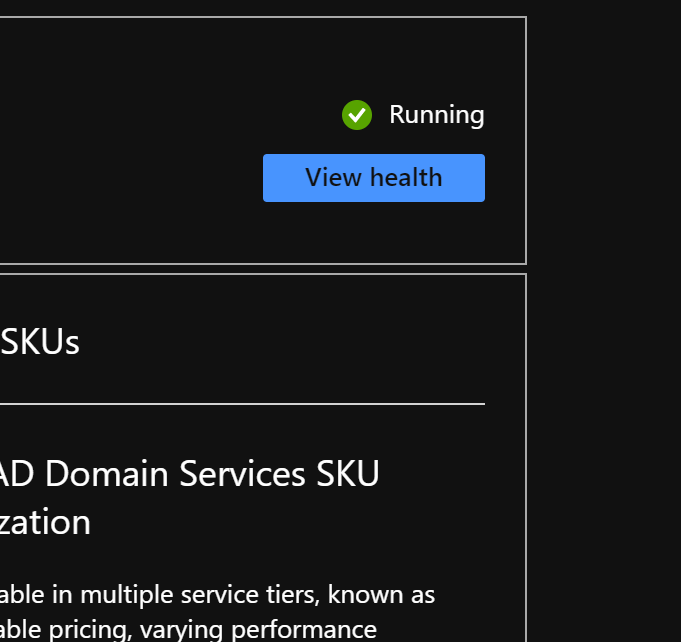



Add the IPs of the 2 AADDS domain controllers to the DNS of the VNET


In [ ]:
Write-Host "Get the IPs of the domain controllers"
$dcIPs = (((Get-AzVirtualNetwork -Name $VNET.Name -ResourceGroupName $VNET.ResourceGroupName -ExpandResource 'subnets/ipConfigurations').subnets | where name -match "aadds-subnet").ipconfigurations).privateipaddress

Write-Host "Add the IPs to the custom DNS of the virtual network"

$object = new-object -type PSObject -Property @{"DnsServers" = $dcIPs}
$vnet.DhcpOptions = $object
$vnet | set-azvirtualnetwork


Create a new virtual machine to configure Group Policy
Utilize the CIS Benchmark 2019 L1 image for security - image name is cis-windows-server-2019-v1-0-0-l1
Add the features for AD DS and Group Policy Management

In [ ]:
$global:vmName = 'aadds-mgmt-01'
$nicName = "aadds-mgmt-nic"

if (Get-AzVM -Name $vmName){
    Write-Host "The management VM has already been created"
} else {
    Write-Host "Getting credentials for the new VM"
    $cred = Get-Credential -Message "Enter a username and password for the virtual machine."

    Write-Host "Create the new NIC"
    if(get-AzNetworkInterface -Name $nicName){
        Write-Host "Nic is already created"
    }else{
        Write-Host "Creating a new NIC"
        $vnet = Get-AzVirtualNetwork
        $subnetID = ($vnet.subnets | where name -match 'aadds-subnet').id
        $nic = New-AzNetworkInterface -Name $nicName -ResourceGroupName $rgName -Location $region -SubnetId $subnetID
    }
    Write-Host "Create the new VM config"
    $VirtualMachine = New-AzVMConfig -VMName $vmName -VMSize 'Standard_D2s_v3'
    $VirtualMachine = Set-AzVMOperatingSystem -VM $VirtualMachine -Windows -ComputerName $vmName -Credential $Cred -ProvisionVMAgent -EnableAutoUpdate
    $VirtualMachine = Add-AzVMNetworkInterface -VM $VirtualMachine -Id $nic.Id
    $VirtualMachine = Set-AzVMSourceImage -VM $VirtualMachine -PublisherName 'MicrosoftWindowsServer' -Offer 'WindowsServer' -Skus '2019-Datacenter' -Version latest
    write-host "Creating the VM $vmName"
    New-AzVM -ResourceGroupName $rgName -Location $region -VM $VirtualMachine -Verbose
    Write-Host "The AADDS management VM has been created"
}

Create an Azure File Shares as premium storage
Add the Profiles share and the Redirections share
Add the redirections.xml to the Redirections share
Give permission to the domain on the shares

In [ ]:
$domain = $ManagedDomainName.split(".")[0]
    $stAcctName = ("wvdstor" + $domain).toLower()
    if ($stAcctName.length -ge 24){
        Write-Host "reducing the name to the first 24 characters"
        $stAcctName = $stAcctName.subString(0,24)
    }

    Write-Host "Removing Special Characters"
    $stAcctName -replace "[^a-zA-Z0-9]"

if (Get-AzStorageAccount -Name $stAcctName -ResourceGroupName $rgName){
    Write-Host "Storage account $stAcctName is already created"
} else {
    Write-Host "Creating new storage account with name of $stAcctName"
    $global:storAcct = New-AzStorageAccount -ResourceGroupName $rgName -Name $stAcctName -SkuName Premium_LRS -Location $region -Kind FileStorage 
}

$profileShare = "profiles"
$redirectShares = "redirections"

if (Get-AzRmStorageShare -ResourceGroupName $rgName -StorageAccountName $stAcctName | Where name -match "Profiles"){
 Write-Host "Profiles share is already created"
} else {
    Write-Host "Creating the profiles share"
    $global:pshare = New-AzRmStorageShare -ResourceGroupName $rgName -StorageAccountName $stAcctName -Name $profileShare -QuotaGiB 100 | Out-Null
}

if (Get-AzRmStorageShare -ResourceGroupName $rgName -StorageAccountName $stAcctName | Where name -match "Redirections"){
 Write-Host "Redirections share is already created"
} else {
    Write-Host "Creating the redirections share"
    $rshare = New-AzRmStorageShare -ResourceGroupName $rgName -StorageAccountName $stAcctName -Name $redirectShares -QuotaGiB 100 | Out-Null
}


Enable AADDS management of the storage account and give File Share Contributor Role to the Profiles share to the WVD_Users group

In [ ]:

Write-Host "Enable AADDS on storage"
Set-AzStorageAccount -ResourceGroupName $rgName -Name $stAcctName -EnableAzureActiveDirectoryDomainServicesForFile $true

Write-Host "Give permissions to the Profiles file share to the WVD_Users group"
#Get the name of the custom role
$FileShareContributorRole = Get-AzRoleDefinition "Storage File Data SMB Share Contributor"
#Constrain the scope to the target file share
$scope = (Get-AzRmStorageShare -ResourceGroupName $rgName -StorageAccountName $stAcctName | Where name -match "Profiles").id
#Assign the custom role to the target identity with the specified scope.
$groupid = (get-azadgroup -DisplayName 'wvd_users').id
New-AzRoleAssignment -ObjectID $groupid  -RoleDefinitionName $FileShareContributorRole.Name -Scope $scope

Create the Redirections.xml file for FSLogix and place it in the Redirections share on Azure Files

In [ ]:
Write-Host "Creating the redirections file"

$redirections = @"
<?xml version="1.0" encoding="UTF-8"?>
<FrxProfileFolderRedirection>
	<Excludes>
		<Exclude>Desktop</Exclude>
		<Exclude>Documents</Exclude>
		<Exclude>Favorites</Exclude>
	</Excludes>
</FrxProfileFolderRedirection>

"@

$redirections | out-file c:\temp\Redirections.xml
Write-Host "Getting the storage share for redirections"
$rshare = (Get-AzRmStorageShare -ResourceGroupName $rgName -StorageAccountName $stAcctName | Where name -match "Redirections").name
Write-Host "Uploadinng the redirections file to the share"
$RedirFile = Set-AzStorageFileContent -Context $storAcct.Context -ShareName $rshare -Source "c:\temp\Redirections.xml" -Path "Redirections.xml"

Create temporary storage account for custom scripts

In [ ]:
$domain = $ManagedDomainName.split(".")[0]
    $cseAcctName = ("cseStor" + $domain).toLower()
    if ($cseAcctName.length -ge 24){
        Write-Host "reducing the name to the first 24 characters"
        $cseAcctName = $cseAcctName.subString(0,24)
    }

    Write-Host "Removing Special Characters"
    $global:cseAcctName -replace "[^a-zA-Z0-9]"

if (Get-AzStorageAccount -Name $cseAcctName -ResourceGroupName $rgName){
    Write-Host "Storage account $cseAcctName is already created"
} else {
    Write-Host "Creating new storage account with name of $cseAcctName"
    $global:cseStorAcct = New-AzStorageAccount -ResourceGroupName $rgName -Name $cseAcctName -SkuName Standard_LRS -Location $region -Kind StorageV2  
}


if (Get-AzStorageContainer -Name 'csecontainer'){
    Write-Host "The container already exists"
} else {
    Write-Host "Creating the container"
    Set-AzCurrentStorageAccount -ResourceGroupName $rgName -Name $cseAcctName
    New-AzStorageContainer -Name 'csecontainer'
}

$domainCred = Get-Credential

if (test-path c:\temp\domainJoin.ps1){
    Write-Host "The domain join script is already created"
} else {
    Write-Host "Create the domain join script"
    $joinDomain = @"
    Add-Computer -DomainName $ManagedDomainName -credential $domainCred -Restart
"@
    $joinDomain | out-file c:\temp\domainJoin.ps1
}

Write-Host "Upload script to container"
Set-AzStorageBlobContent -Container "csecontainer" -File "c:\temp\domainJoin.ps1" -Blob "domainJoin.ps1"

Add the domain join custom script to the extension of the VM

In [ ]:

# Get the VM we need to configure
$vm = Get-AzVM -ResourceGroupName $rgName -Name $VMName
# Get storage account key
$key = (Get-AzStorageAccountKey -Name $cseAcctName -ResourceGroupName $rgName)[0].Value
## Enable the custom script extension and run the script
Write-Host "Adding Custom Script Extension to VM"
Set-AzVMCustomScriptExtension -ResourceGroupName $rgName -VMName $VMName -Name domainJoin.ps1 -Location $vm.Location -StorageAccountName $cseAcctName -StorageAccountKey $key -FileName domainJoin.ps1 -ContainerNam 'csecontainer' -Run domainJoin.ps1

Add the AADDS Management virtual machine to the domain

In [ ]:
$domaincred = Get-Credential
Write-Host "Adding the AADDS management VM to the AADDS domain"
Set-AzVMADDomainExtension -DomainName $ManagedDomainName -ResourceGroupName $rgName -VMName $vmName -Credential $domaincred -JoinOption '0x00000003' -Restart -Verbose
Write-Host "The virtual machine has been added to the domain and is restarting"

Create your WVD

Test